In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [17]:
# import dataset
df = pd.read_csv("dnd_monsters.csv")
df.head()

,name,url,cr,type,size,ac,hp,speed,align,legendary,source,str,dex,con,int,wis,cha
0,aarakocra,https://www.aidedd.org/dnd/monstres.php?vo=aar...,1/4,humanoid (aarakocra),Medium,12,13,fly,neutral good,NaN,Monster Manual (BR),10.0,14.0,10.0,11.0,12.0,11.0
1,abjurer,NaN,9,humanoid (any race),Medium,12,84,NaN,any alignment,NaN,Volo's Guide to Monsters,NaN,NaN,NaN,NaN,NaN,NaN
2,aboleth,https://www.aidedd.org/dnd/monstres.php?vo=abo...,10,aberration,Large,17,135,swim,lawful evil,Legendary,Monster Manual (SRD),21.0,9.0,15.0,18.0,15.0,18.0
3,abominable-yeti,NaN,9,monstrosity,Huge,15,137,NaN,chaotic evil,NaN,Monster Manual,NaN,NaN,NaN,NaN,NaN,NaN
4,acererak,NaN,23,undead,Medium,21,285,NaN,neutral evil,NaN,Adventures (Tomb of Annihilation),NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# dropping out unncesarry columns
used_columns = ['cr', 'ac', 'hp', 'str', 'dex', 'con', 'int', 'wis', 'cha']
df = df[used_columns]
df

,cr,ac,hp,str,dex,con,int,wis,cha
0,1/4,12,13,10.0,14.0,10.0,11.0,12.0,11.0
1,9,12,84,NaN,NaN,NaN,NaN,NaN,NaN
2,10,17,135,21.0,9.0,15.0,18.0,15.0,18.0
3,9,15,137,NaN,NaN,NaN,NaN,NaN,NaN
4,23,21,285,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
757,1,11,40,11.0,12.0,11.0,13.0,12.0,14.0
758,22,21,307,NaN,NaN,NaN,NaN,NaN,NaN
759,26,21,580,27.0,24.0,28.0,26.0,27.0,30.0
760,1/4,8,22,13.0,6.0,16.0,3.0,6.0,5.0


In [19]:
# check for nans
nans = dict()
for column in used_columns:
    nans[column] = int(df[column].isna().sum())

nans

{'cr': 1,
 'ac': 0,
 'hp': 0,
 'str': 361,
 'dex': 361,
 'con': 361,
 'int': 361,
 'wis': 361,
 'cha': 361}

In [20]:
# it seems like we have a lot of nans in the attribute scores ([str]ength, [dex]terity, [con]stitution, [int]elligence, [wis]dom, [cha]risma)
# we will be able to check the other 2 things compared to cd (it's overall level):
# ac (armor class, it might have class in the name but it is simply a number showing how hard it is to hit)
# hp (hit points)

# let's check on that 1 missing cr
df[df['cr'].isna()]

,cr,ac,hp,str,dex,con,int,wis,cha
22,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# since it is empty I'll just get rid of it
df = df[df['cr'].isna() == False]

In [22]:
df.head()

,cr,ac,hp,str,dex,con,int,wis,cha
0,1/4,12,13,10.0,14.0,10.0,11.0,12.0,11.0
1,9,12,84,NaN,NaN,NaN,NaN,NaN,NaN
2,10,17,135,21.0,9.0,15.0,18.0,15.0,18.0
3,9,15,137,NaN,NaN,NaN,NaN,NaN,NaN
4,23,21,285,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# as we can see some of the CR-s is not exactly in number format, as 1/4 and 1/2 exists as CR-s
def cr_standardiser(x) -> float:
    try:
        return float(x)
    except ValueError:
        if x == '1/8':
            return 0.125
        elif x == '1/4':
            return 0.25
        elif x == '1/2':
            return 0.5
        else:
            raise ValueError(f'unexpected value: {x}')

df['cr'] = df['cr'].apply(cr_standardiser)
df.head()

C:\Users\Felhasznalo\AppData\Local\Temp\ipykernel_16296\2159012187.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cr'] = df['cr'].apply(cr_standardiser)


,cr,ac,hp,str,dex,con,int,wis,cha
0,0.25,12,13,10.0,14.0,10.0,11.0,12.0,11.0
1,9.00,12,84,NaN,NaN,NaN,NaN,NaN,NaN
2,10.00,17,135,21.0,9.0,15.0,18.0,15.0,18.0
3,9.00,15,137,NaN,NaN,NaN,NaN,NaN,NaN
4,23.00,21,285,NaN,NaN,NaN,NaN,NaN,NaN


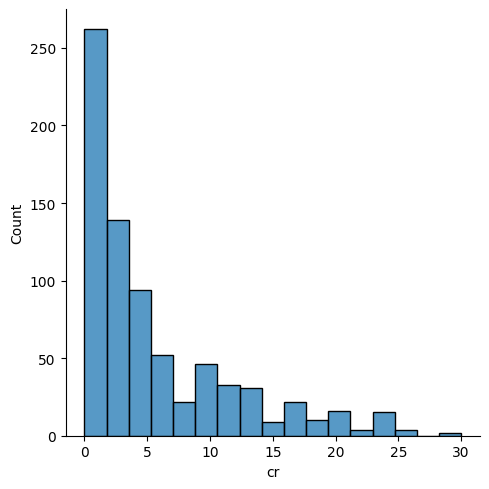

In [24]:
# let's see our cr mix
sns.displot(df['cr'])

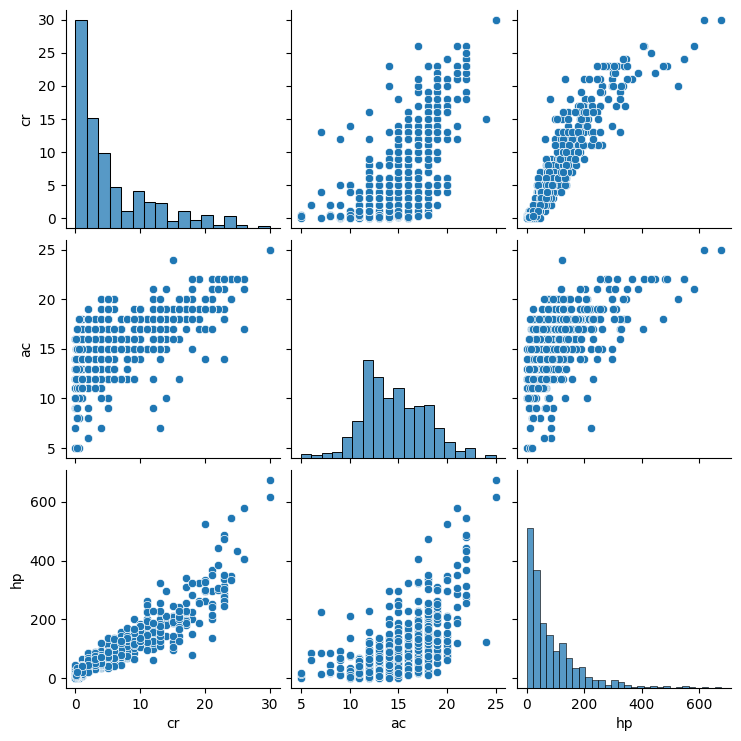

In [25]:
# from the looks of it this is actually all monsters from dnd
# we have way more data on low levels (low cr), which could be an issue but we can just weed out some of it
sns.pairplot(df[['cr', 'ac', 'hp']])

In [34]:
# we can se that hp is quite nice and linear while the ac is a bit too spread and probably won't land us good results
# let's split our data up for training and testing
# we'll use cr as the support variable while hp as target variable
sup_var = df[['cr']]
tar_var = df['hp']

sup_train, sup_test, tar_train, tar_test = train_test_split(sup_var, tar_var, test_size= 0.3)
# for now I'm leaving the seed random as I don't need it to be stable yet and can help find problems

In [35]:
# let's get our model ready and fit it
model = LinearRegression()
model.fit(sup_train, tar_train)

LinearRegression()

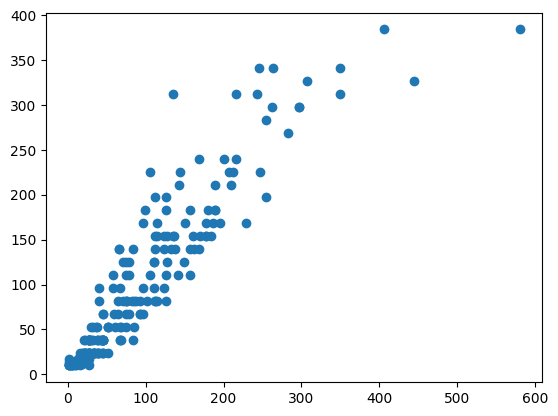

In [36]:
predictions = model.predict(sup_test)
plt.scatter(tar_test, predictions)
plt.show()

In [37]:
# let's get actual numeric data on it's accuaricy

print(f"MAE\n{round(metrics.mean_absolute_error(tar_test, predictions), 2)}")
print(f"nMSE\n{round(metrics.mean_squared_error(tar_test, predictions), 2)}")
print(f"nR-squared\n{round(metrics.r2_score(tar_test, predictions), 2)}")

MAE
20.82
nMSE
1165.45
nR-squared
0.85


In [44]:
# while 0.85ish (moves around since we didn't fix the seed) r^2 might look a bit weak
# but since these values are not scientific and can warry based on a lot of factors like other abilities of a monster
# an 0.85 is actually a quite acceptable value, let's make a few tests with it
test_cr_s = [1, 2, 5, 7, 11, 20]
tester = {
    'cr': test_cr_s
}
tester = pd.DataFrame(tester)

In [47]:
result = model.predict(tester)
result

array([ 24.12703757,  38.53475765,  81.7579179 , 110.57335806,
       168.20423839, 297.87371914])

In [ ]:
# these results actually seem quite reasonable for the game and can work well for monster creation